In [ ]:
!python -m pip install  -r requirements.txt

In [2]:
import numpy as np
import pandas as pd

# regular expression
import re

# nltk
import gensim
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

# plot
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CMazik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2> Data Loading <h2>

In [3]:
fake_data_path = "data\Fake.csv"
true_data_path = "data\True.csv"

In [4]:
fake_data = pd.read_csv(fake_data_path)
# Labeling data
fake_data['class'] = 0
fake_data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [5]:
true_data = pd.read_csv(true_data_path)
# Labeling data
true_data['class'] = 1
true_data.head()

,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [6]:
full_data = pd.concat([true_data, fake_data], axis=0)

<h2> Data Processing <h2>

In [7]:
# Remove duplicate data
full_data = full_data.drop_duplicates()

In [8]:
# Merger 2 columns: title and text
full_data['title_text'] = full_data['title'] + full_data['text']

In [9]:
full_data.drop(labels=['title', 'text', 'subject', 'date'], axis=1, inplace=True)

In [10]:
full_data.head()

,class,title_text
0,1,"As U.S. budget fight looms, Republicans flip t..."
1,1,U.S. military to accept transgender recruits o...
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,1,FBI Russia probe helped by Australian diplomat...
4,1,Trump wants Postal Service to charge 'much mor...


<h4> Data Cleaning <h4>

In [11]:
def clean_sentence(sentence):
    #remove HTML Tag
    sentence = sentence.lower()
    cleanr = re.compile('<.*?>')
    sentence_cleaned = re.sub(cleanr, '', sentence)
    #remove punctuation
    sentence_cleaned = re.sub(r'[^\w\s]', '', sentence_cleaned)
    return sentence_cleaned

In [12]:
def remove_stop_words(sentence):
    stop_words = set(stopwords.words("english"))
    words = nltk.word_tokenize(sentence)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

In [13]:
final_string = []
for sentence in full_data['title_text']:
    sentence = clean_sentence(sentence)
    sentence = remove_stop_words(sentence)
    final_string.append(sentence)

In [14]:
full_data['clean_sentence'] = final_string

In [15]:
full_data.head()

,class,title_text,clean_sentence
0,1,"As U.S. budget fight looms, Republicans flip t...",us budget fight looms republicans flip fiscal ...
1,1,U.S. military to accept transgender recruits o...,us military accept transgender recruits monday...
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,senior us republican senator let mr mueller jo...
3,1,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped australian diplomat ti...
4,1,Trump wants Postal Service to charge 'much mor...,trump wants postal service charge much amazon ...


<h4> Converting word to vector <h4>

In [16]:
# Load the pre-trained model of Work2Vec
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('pre-train-model\GoogleNews-vectors-negative300.bin', binary=True)

In [17]:
def sentence_to_vector(sentence):
    # Tokenize the sentence
    words = word_tokenize(sentence)
    # Average the word vectors
    valid_words = [word for word in words if word in w2v_model.index_to_key]
    sentence_vector = sum([w2v_model[word] for word in valid_words]) / len(valid_words)
    return sentence_vector

Since it takes a long time to convert words to vectors in whole data, you can use a sub-data to train and test the model.

In [18]:
crop_full_data = full_data.groupby('class').head(100)

In [19]:
crop_full_data

,class,title_text,clean_sentence
0,1,"As U.S. budget fight looms, Republicans flip t...",us budget fight looms republicans flip fiscal ...
1,1,U.S. military to accept transgender recruits o...,us military accept transgender recruits monday...
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,senior us republican senator let mr mueller jo...
3,1,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped australian diplomat ti...
4,1,Trump wants Postal Service to charge 'much mor...,trump wants postal service charge much amazon ...
...,...,...,...
95,0,Roy Moore Supporting Republican LOSES It Afte...,roy moore supporting republican loses called e...
96,0,That Story Trump Just Told The Press About Ob...,story trump told press obama air force one nev...
97,0,This 4-Year Old Tweet From Donald Trump Shows...,4year old tweet donald trump shows us hes leas...
98,0,OOPS: Trump Judicial Nominee Didn’t Tell Cong...,oops trump judicial nominee didnt tell congres...


In [20]:
# Shuffer data
crop_full_data = crop_full_data.sample(frac=1, random_state=42)
crop_full_data.head(15)

,class,title_text,clean_sentence
95,1,House panel chair introduces $81 billion disas...,house panel chair introduces 81 billion disast...
15,1,Virginia officials postpone lottery drawing to...,virginia officials postpone lottery drawing de...
30,1,Alabama to certify Democrat Jones winner of Se...,alabama certify democrat jones winner senate e...
58,0,Trump Supporters Object To Prince Harry’s Rec...,trump supporters object prince harrys recent e...
28,0,Liberal Group Trolls Trump At Roy Moore Rally...,liberal group trolls trump roy moore rally bes...
15,0,Tone Deaf Trump: Congrats Rep. Scalise On Los...,tone deaf trump congrats rep scalise losing we...
69,1,White House expects Congress to waive spending...,white house expects congress waive spending cu...
70,0,"Ivanka Defends Malia Obama From Attacks, Her ...",ivanka defends malia obama attacks dads fans w...
74,0,New York Times Reports There’s An Actual Russ...,new york times reports theres actual russian a...
45,1,Second U.S. judge blocks Trump administration ...,second us judge blocks trump administration bi...


In [21]:
clean_sentence_vector = []
for sentence in crop_full_data['clean_sentence']:
    vector = sentence_to_vector(sentence)
    clean_sentence_vector.append(vector)

<h2> Build Model <h2>

<h4> Split data <h4>

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(clean_sentence_vector, crop_full_data['class'], test_size=0.1, random_state=30, stratify=crop_full_data['class'])

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=30, stratify=y_train)

<h4>Logistic regression model <h4>

In [23]:
# Train the logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict the target values for the validation set
y_val_pred = clf.predict(X_val)

# Predict the target values for the test set
y_test_pred = clf.predict(X_test)


In [24]:
# Calculate the accuracy of the model on the validation set
val_acc_LR = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy LR:", val_acc_LR)
# Calculate the accuracy of the model on the test set
test_acc_LR = accuracy_score(y_test, y_test_pred)
print("Test Accuracy LR:", test_acc_LR)
# Calculate the F1 score of the model on the test set
f1_LR = f1_score(y_test, y_test_pred)
print("F1 Score LR:", f1_LR)

Validation Accuracy LR: 1.0
Test Accuracy LR: 0.9
F1 Score LR: 0.9090909090909091


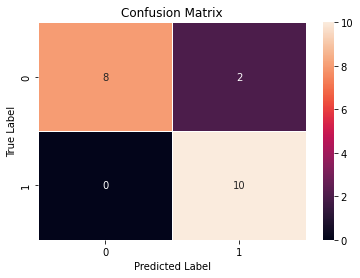

In [25]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, linewidths=1, annot=True, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<h4>SVM model <h4>

In [26]:
# Train the SVM model
clf = SVC()
clf.fit(X_train, y_train)

# Predict the target values for the validation set
y_val_pred_SVM = clf.predict(X_val)

# Predict the target values for the test set
y_test_pred_SVM = clf.predict(X_test)

In [27]:
# Calculate the accuracy of the model on the validation set
val_acc_SVM = accuracy_score(y_val, y_val_pred_SVM)
print("Validation Accuracy SVM:", val_acc_SVM)
# Calculate the accuracy of the model on the test set
test_acc_SVM = accuracy_score(y_test, y_test_pred_SVM)
print("Test Accuracy SVM:", test_acc_SVM)
# Calculate the F1 score of the model on the test set
f1_SVM = f1_score(y_test, y_test_pred_SVM)
print("F1 Score SVM:", f1_SVM)

Validation Accuracy SVM: 1.0
Test Accuracy SVM: 1.0
F1 Score SVM: 1.0


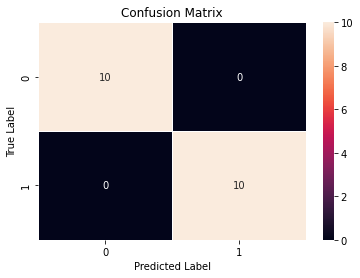

In [28]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_SVM)
sns.heatmap(cm, linewidths=1, annot=True, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<h4>Stochastic Gradient Descent (SGD) model<h4>

In [29]:
# Train the SGD
clf = SGDClassifier()
clf.fit(X_train, y_train)

# Predict the target values for the validation set
y_val_pred_SGD = clf.predict(X_val)

# Predict the target values for the test set
y_test_pred_SGD = clf.predict(X_test)

In [30]:
# Calculate the accuracy of the model on the validation set
val_acc_SGD = accuracy_score(y_val, y_val_pred_SGD)
print("Validation Accuracy SVM:", val_acc_SGD)
# Calculate the accuracy of the model on the test set
test_acc_SGD = accuracy_score(y_test, y_test_pred_SGD)
print("Test Accuracy SVM:", test_acc_SGD)
# Calculate the F1 score of the model on the test set
f1_SGD = f1_score(y_test, y_test_pred_SGD)
print("F1 Score SVM:", f1_SGD)

Validation Accuracy SVM: 1.0
Test Accuracy SVM: 1.0
F1 Score SVM: 1.0


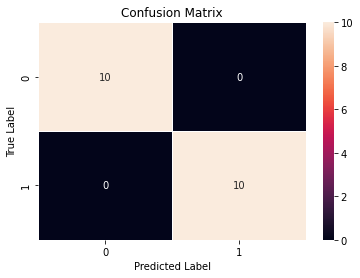

In [31]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_SGD)
sns.heatmap(cm, linewidths=1, annot=True, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<h4>Decision Tree model<h4>

In [32]:
# Train the Decision Tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Predict the target values for the validation set
y_val_pred_DT = clf.predict(X_val)

# Predict the target values for the test set
y_test_pred_DT = clf.predict(X_test)

In [33]:
# Calculate the accuracy of the model on the validation set
val_acc_DT = accuracy_score(y_val, y_val_pred_DT)
print("Validation Accuracy SVM:", val_acc_DT)
# Calculate the accuracy of the model on the test set
test_acc_DT = accuracy_score(y_test, y_test_pred_DT)
print("Test Accuracy SVM:", test_acc_DT)
# Calculate the F1 score of the model on the test set
f1_DT = f1_score(y_test, y_test_pred_DT)
print("F1 Score SVM:", f1_DT)

Validation Accuracy SVM: 1.0
Test Accuracy SVM: 0.8
F1 Score SVM: 0.8000000000000002


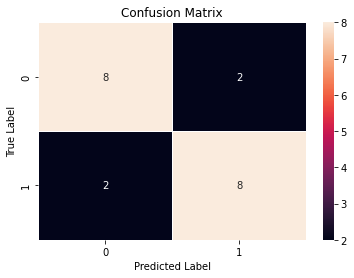

In [34]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_DT)
sns.heatmap(cm, linewidths=1, annot=True, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()